# Frog survival likelihood

The goal of this exercise is to estimate the probability of death given the frog type. The dataset contains the following columns:

* density = initial tadpole density (number of tadpoles in a 1.2 x 0.8 x 0.4 m tank)
* pred = factor: predators present or absent
* size = factor: big or small tadpoles
* surv = number surviving
* propsurv = proportion surviving (=surv/density)

## 1. Packages and load data

In [1]:
# import package
import pandas as pd

# load data
rfp = pd.read_csv('data/reed_frog.csv', index_col=0)
rfp.head()

,density,pred,size,surv,propsurv
1,10,no,big,9,0.9
2,10,no,big,10,1.0
3,10,no,big,7,0.7
4,10,no,big,10,1.0
5,10,no,small,9,0.9


In [2]:
rfp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 1 to 48
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   density   48 non-null     int64  
 1   pred      48 non-null     object 
 2   size      48 non-null     object 
 3   surv      48 non-null     int64  
 4   propsurv  48 non-null     float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.2+ KB


## 2. Explore data

In [3]:
# P(death) where there was a predator and only for small frogs (with total initial frog concentration of 10)
rf_sub = rfp[(rfp['pred'] == 'pred') & (rfp['size'] == 'small') & (rfp['density'] == 10)].copy()
rf_sub

,density,pred,size,surv,propsurv
13,10,pred,small,7,0.7
14,10,pred,small,5,0.5
15,10,pred,small,9,0.9
16,10,pred,small,9,0.9


In [4]:
# create frog 'killed' column
rf_sub['killed'] = rf_sub['density'] - rf_sub['surv']
rf_sub

,density,pred,size,surv,propsurv,killed
13,10,pred,small,7,0.7,3
14,10,pred,small,5,0.5,5
15,10,pred,small,9,0.9,1
16,10,pred,small,9,0.9,1


## 3. Estimate the probability of death

What we need to keep in mind:

- the pre-trial probability is binomia (survive or die)
- we need N (density), k (number of killed frogs) and p (success probability)
- when we have multiple observations the likelihood function becomes a product of all likelihoods

In [6]:
# likelihood for binomial data (import binom)
from scipy.stats import binom

# import numpy
import numpy as np

In [9]:
# probability of survive
p = 0.5

# sum of all data points
np.sum(binom.logpmf(k=rf_sub['killed'], n=rf_sub['density'], p=p))

-12.803796206116246

### 3.1 Brute force method

In [10]:
# take multiple p values (from 0 to 1)
# calculate the likelihood for all p values

In [17]:
# p values range
p_vec = np.arange(0.01, 1.01, step=0.01)

# likelihood array creation
lik = np.zeros(100)

# for loop likelihood for all p values
for i, p in enumerate(p_vec):
    lik[i] = np.prod(binom.pmf(k=rf_sub['killed'], n=rf_sub['density'], p=p))

In [18]:
# import pyplot
from matplotlib import pyplot as plt

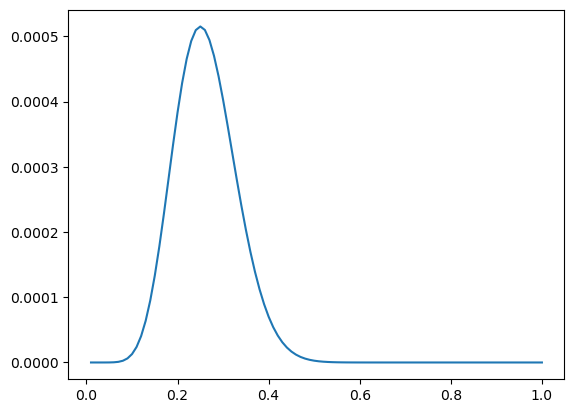

In [20]:
plt.plot(p_vec, lik);

### 3.2 Maximized log-likelihood

Best value: p=0.25


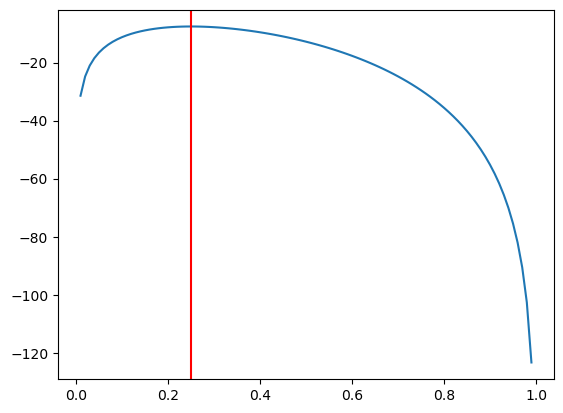

In [27]:
# same setup but for log-likelihood
p_vec = np.arange(0.01, 1.01, step=0.01)
loglik = np.zeros(100)

# for loop -> sum of log-likelihood using logpmf
for i, p in enumerate(p_vec):
    loglik[i] = np.sum(binom.logpmf(k=rf_sub['killed'], n=rf_sub['density'], p=p))
    
# find max p for argument loglik
max_p = p_vec[np.argmax(loglik)]

# print max_p
print(f'Best value: p={max_p}')

# plot
plt.plot(p_vec, loglik)
plt.axvline(x=max_p, color='r', linestyle='-');

## 4. Maximum likelihood estimation (MLE)

- use the MLE optimizer to estimate the parameter p
- to minimize -> opposite of maximizing -> need to take the negative log-likelihood

In [30]:
# import minimize
from scipy.optimize import minimize

# negative log-likelihood function
def neg_LL(p):
    LL = np.sum(binom.logpmf(k=rf_sub["killed"], n=rf_sub["density"], p=p[0]))
    neg_LL = -LL
    return neg_LL

In [36]:
# mle model
mle_model = minimize(neg_LL, x0=0.5, bounds=[(1e-10, 1-1e-10)])
mle_model

      fun: 7.571314768470774
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.66453525e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 16
      nit: 6
     njev: 8
   status: 0
  success: True
        x: array([0.24999999])

### 4.1 MLE big frogs vs small frogs

Do bigger frogs have a higher survival probability?

In [38]:
# select tanks with predators and big frogs only
rf_sub_b = rfp[(rfp["pred"]=="pred") & (rfp["size"]=="big") & (rfp["density"]==10)].copy()

# killed = density - survived
rf_sub_b["killed"] = rf_sub_b["density"] - rf_sub_b["surv"]

# negative log-likelihood function
def neg_LL(p):
    LL = np.sum(binom.logpmf(k=rf_sub_b["killed"], n=rf_sub_b["density"], p=p[0]))
    neg_LL = -LL
    return neg_LL

In [39]:
# mle model
mle_model = minimize(neg_LL, x0=.5, bounds=[(1e-10, 1-1e-10)])
mle_model

      fun: 8.113573664174268
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([0.35])

- bigger frogs have a higher risk of being killed (p = 0.35 vs 0.25 overall)

## 5. Bayesian parameter estimation

- required a prior
- if prior missing, a non-informative prior can be used

In [40]:
# import uniform
from scipy.stats import uniform

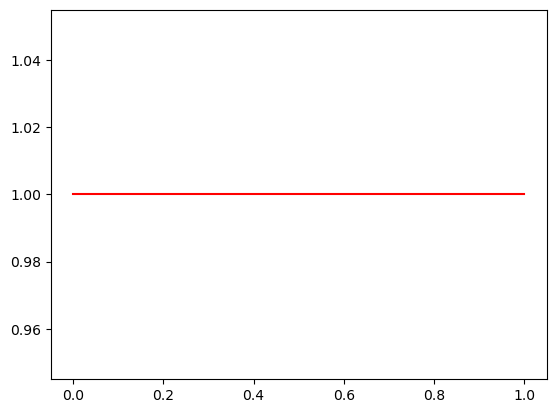

In [44]:
# create non-informative prior
p_vec = np.arange(0, 1.01, step=0.01)
p_uni = uniform.pdf(p_vec)

# plot
plt.plot(p_vec, p_uni, "r");

- binomia distributed data have a beta distribution as it conjugate prior (non-informative)

In [42]:
# import beta
from scipy.stats import beta

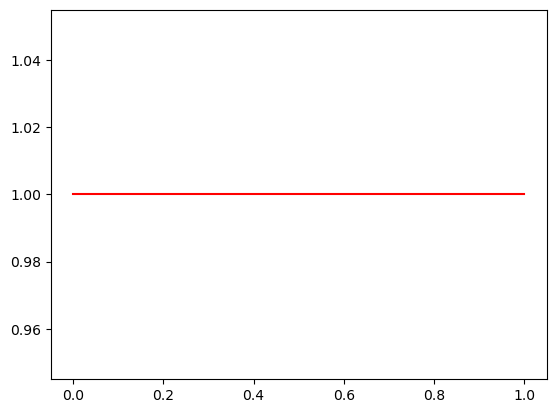

In [45]:
# non-informative beta prior
p_vec = np.arange(0, 1.01, step=0.01)
p_beta = beta.pdf(p_vec, 1, 1)

# plot
plt.plot(p_vec, p_beta, "r");

### 5.1 Single data point (brute force method of bayesian estimation)

- let's focus on a single data point example
- one tank N=10 and 3 frogs are missing

In [54]:
# killed frogs
k_killed = 3

# p parameter range
param_space = np.arange(0, 1.001, step=.001)

#likelihood
likelihood = binom.pmf(k=k_killed, n=10, p=param_space)

In [57]:
# brute-force bayesian estimation

# prior across parameter space 
prior = beta.pdf(param_space, a=1, b=1)

# numerator for bayes rule
# weight the data likelihood by the prior
weighted_likelihood = likelihood*prior

# denominator for bayes rule
# compute normalization constant
# evidence is a single constant number -> the sum of the weighted likelihoods
normalization_constant = np.sum(weighted_likelihood)/len(param_space)

# posterior -> (numerator/denominator)
# apply bayes rule
posterior = weighted_likelihood/normalization_constant

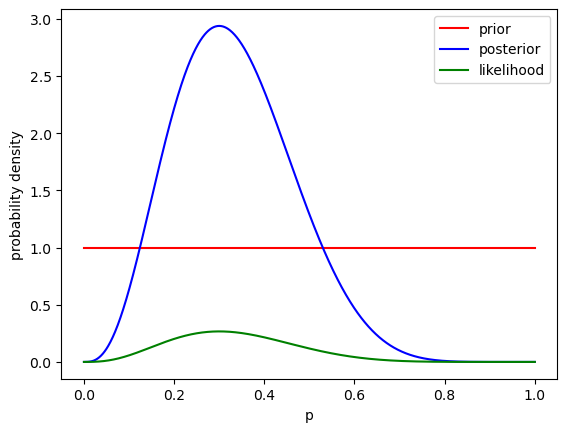

In [58]:
# plot
plt.plot(param_space, prior, "r", label="prior")
plt.plot(param_space, posterior, "b", label="posterior")
plt.plot(param_space, likelihood, "g", label="likelihood")
plt.legend()
plt.xlabel("p")
plt.ylabel("probability density");

- posterios and likelihood have "similar shapes"

### 5.2 Single data point (informative prior)

In [59]:
# informative prior

# set informative prior
prior = beta.pdf(param_space, a=15, b=5)

# numerator for bayes rule
# weight the data likelihood by the prior
weighted_likelihood = likelihood*prior

# denominator for bayes rule
# compute normalization constant
# evidence is a single constant number -> the sum of the weighted likelihoods
normalization_constant = np.sum(weighted_likelihood)/len(param_space)

# posterior -> (numerator/denominator)
# apply bayes rule
posterior = weighted_likelihood/normalization_constant

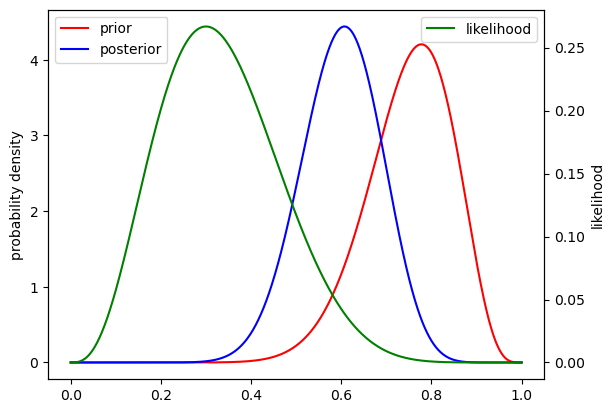

In [63]:
# plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(param_space, prior, "r", label="prior")
ax1.plot(param_space, posterior, "b", label="posterior")
ax2.plot(param_space, likelihood, "g", label="likelihood")
ax1.legend()
ax2.legend()
plt.xlabel("p")
ax1.set_ylabel("probability density")
ax2.set_ylabel("likelihood");

- posterior is in between prior and likelihood and has the same shape as prior

### 5.3 Multiple data point (brute force method)

- individual data points are statistically independent -> likelihood function is the product of all individual samples

In [65]:
# given killed frogs on different tanks
k_killed = [3, 1, 6, 2, 3, 2, 6, 1, 3, 3]

# use latest prior as before
prior = beta.pdf(param_space, a=15, b=5)

# likelihood -> product of all individual samples
likelihood = [np.prod(binom.pmf(k=k_killed, n=10, p=p)) for p in param_space]

# numerator for bayes
weighted_likelihood = likelihood*prior

# denominator for bayes
normalization_constant = np.sum(weighted_likelihood)/len(param_space)

# posterior
posterior = weighted_likelihood/normalization_constant

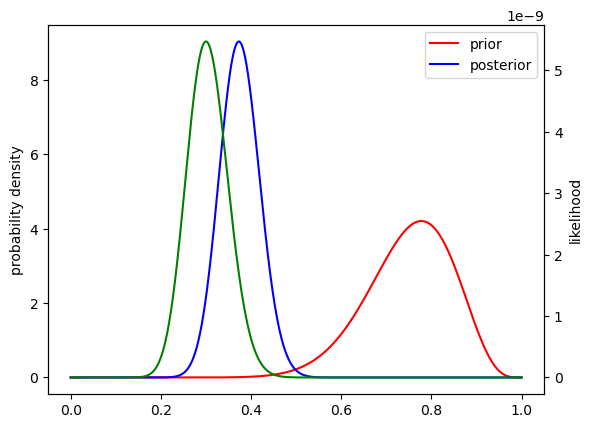

In [66]:
# plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(param_space, prior, "r", label="prior")
ax1.plot(param_space, posterior, "b", label="posterior")
ax2.plot(param_space, likelihood, "g", label="likelihood")
ax1.legend()
plt.xlabel("p")
ax1.set_ylabel("probability density")
ax2.set_ylabel("likelihood");

- posterior is closer to likelihood as there is more data

### 5.4 Multiple data point (informative prior)

- informative prior method
- a = 150
- b = 50

In [67]:
# use latest prior as before
prior = beta.pdf(param_space, a=150, b=50)

# likelihood -> product of all individual samples
likelihood = [np.prod(binom.pmf(k=k_killed, n=10, p=p)) for p in param_space]

# numerator for bayes
weighted_likelihood = likelihood*prior

# denominator for bayes
normalization_constant = np.sum(weighted_likelihood)/len(param_space)

# posterior
posterior = weighted_likelihood/normalization_constant

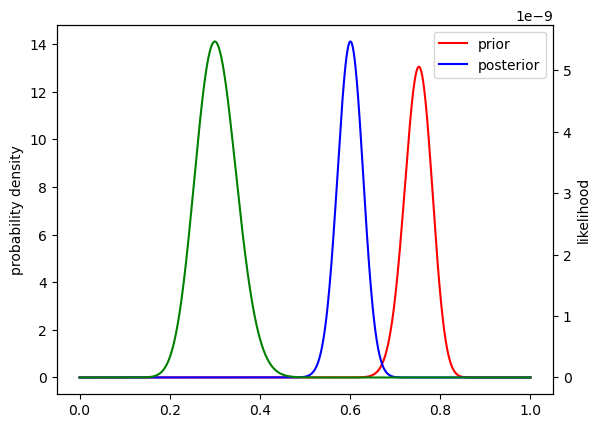

In [68]:
# plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(param_space, prior, "r", label="prior")
ax1.plot(param_space, posterior, "b", label="posterior")
ax2.plot(param_space, likelihood, "g", label="likelihood")
ax1.legend()
plt.xlabel("p")
ax1.set_ylabel("probability density")
ax2.set_ylabel("likelihood");

### 5.5 Bayesian credible intervals (confidence intervals)

- credible intervals -> 95% sure that the parameter values is between the lower and upper bound of this interval
- k = 3
- non-informative prior a=1 and b=1
- To the posterior distribution: $Posterior \propto Beta(a+k, b+N-k)$

In [69]:
# killed
k_killed = 3

# tank size
N = 10

# posterior
posterior = beta.pdf(param_space, a=1+k_killed, b=1+(N-k_killed))

# credible interval
credible_interval = beta.ppf([0.025, 0.975], a=1+k_killed, b=1+(N-k_killed))

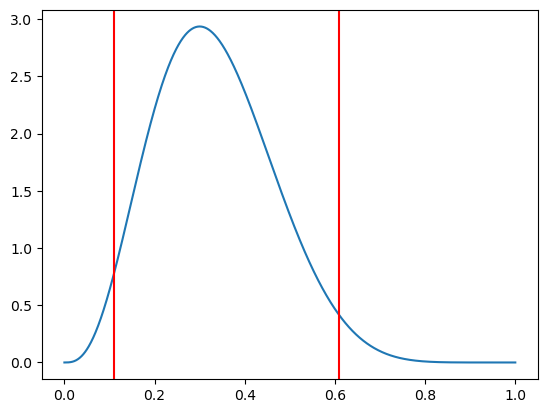

In [70]:
# plot
plt.plot(param_space, posterior)
plt.axvline(x=credible_interval[0], color="r")
plt.axvline(x=credible_interval[1], color="r");